# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import numpy as np
from scipy.stats import spearmanr
from kneed import KneeLocator
import json

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-13 10:24:25.315812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 10:24:25.560470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 10:24:25.655254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 10:24:26.091066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFl

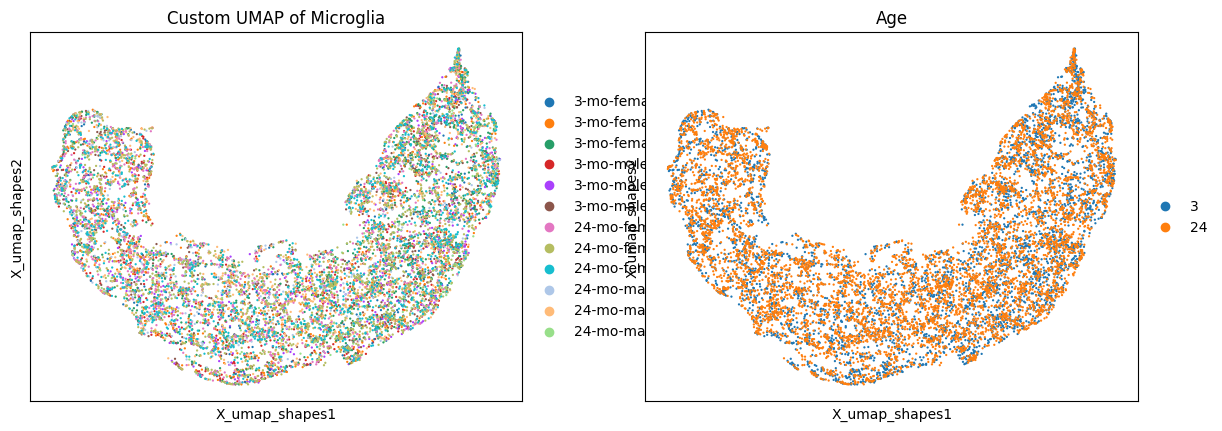

In [2]:
# Now we can go ahead and create a umap for this:

adata = sc.read_h5ad('Microglia_cuttlefish_500_block5_conv1.h5ad')
adata = adata[~adata.obs['texture'].isna()].copy()

vector_list = [json.loads(vec) if pd.notnull(vec) else np.zeros(512) for vec in adata.obs['texture']]
vector_matrix = np.array(vector_list)

# Step 2: Perform PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(vector_matrix)

# Step 3: Calculate UMAP
n_neighbors = 10
umap_model = umap.UMAP(n_neighbors=n_neighbors)
umap_embedding = umap_model.fit_transform(principal_components)

adata.obsm['X_pca'] = principal_components

# Step 4: Add UMAP embedding to AnnData object
adata.obsm['X_umap_shapes'] = umap_embedding

# Example of how to plot UMAP embedding using scanpy, colored by batchID
sc.pl.embedding(adata, basis='X_umap_shapes', color=['batchID', 'Age'], title='Custom UMAP of Microglia')

adata.write_h5ad('Microglia_cuttlefish_500_block5_conv1_umap.h5ad')

In [3]:
feature_vectors = pd.read_csv('feature_vectors_texture.csv')
df_vectors = feature_vectors.copy()

ad_parent = sc.read_h5ad('Microglia_cuttlefish_500_block5_conv1_umap.h5ad')

adata = ad_parent[ad_parent.obs.updated_celltype == 'Microglia']

merged_df = adata.obs.reset_index().merge(df_vectors, on=['Name'], how='left').set_index('index')
adata.obs = merged_df

start_index = list(adata.obs.columns).index('Cell Area')
columns_after_specific = adata.obs.iloc[:, start_index:-3].values

morphological_columns = adata.obs.columns[start_index:-3]

start_index = list(adata.obs.columns).index('Cell Area')  # Add 1 to include the column itself
columns_after_specific = adata.obs.iloc[:, start_index:-3].values

morphological_columns = adata.obs.columns[start_index:-3]

non_na_columns = morphological_columns[~adata.obs[morphological_columns].isna().all()]

# Identify rows with any NaN values in the morphological factors
rows_with_nan = adata.obs[non_na_columns].isna().all(axis=1)

# Subset the AnnData object to remove rows with NaN values
adata = adata[~rows_with_nan].copy()

vector_list = [json.loads(vec) if pd.notnull(vec) else np.zeros(512) for vec in adata.obs['texture']]
vector_matrix = np.array(vector_list)

pca = PCA(n_components=10)
principal_components = pca.fit_transform(vector_matrix)

n_neighbors = 10
umap_model = umap.UMAP(n_neighbors=n_neighbors)
umap_embedding = umap_model.fit_transform(principal_components)

adata.obsm['X_pca'] = principal_components

adata.obsm['X_umap_shapes'] = umap_embedding

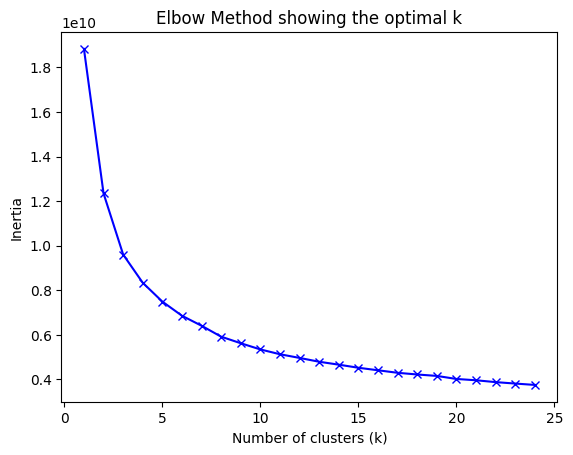

The optimal number of clusters is 5


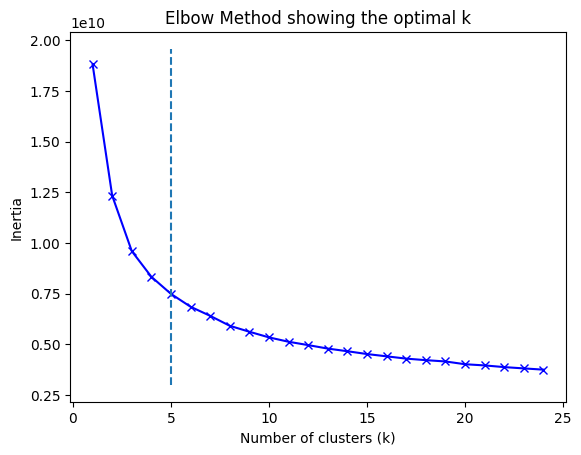

In [6]:
# What is the right number of clusters?
inertia = []
k_values = range(1, 25)  # You can adjust the range as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=45)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method showing the optimal k')
plt.show()

# Create the KneeLocator object
kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')

# Get the elbow point
optimal_k = kneedle.elbow

print(f'The optimal number of clusters is {optimal_k}')

plt.plot(k_values, inertia, 'bx-')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method showing the optimal k')
plt.show()

In [10]:
kmeans = KMeans(n_clusters=optimal_k, random_state=45)
adata.obs['morph_leiden'] = kmeans.fit_predict(adata.obsm['X_pca'])
adata.obs['morph_leiden'] = adata.obs['morph_leiden'].astype('category')

adata.write_h5ad('Shape_500.h5ad')

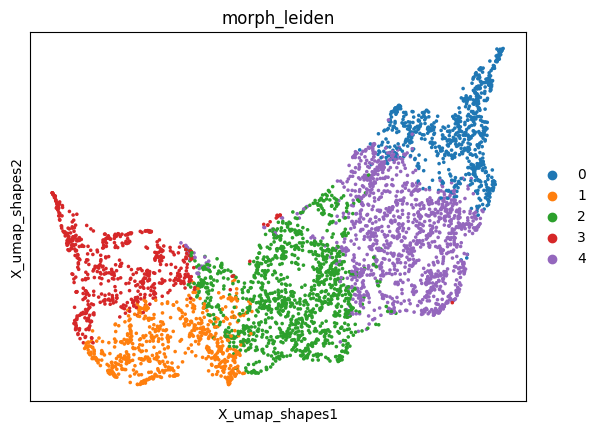

In [11]:
sc.pl.embedding(adata, basis='X_umap_shapes',color='morph_leiden')